In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx

import time

In [4]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))


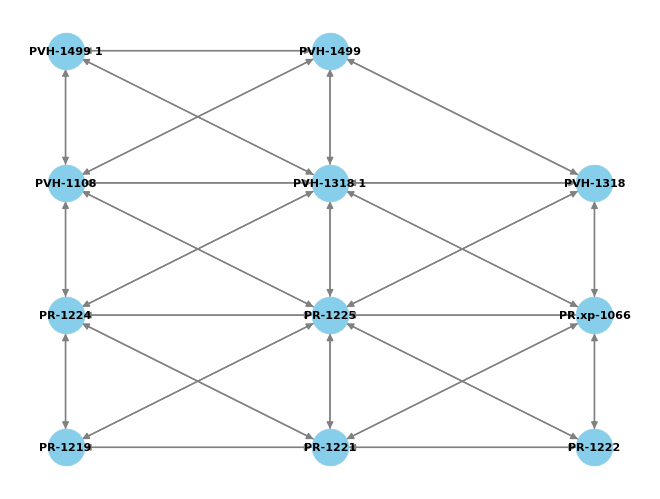

In [5]:
#%%
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 3:
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections within 200m')
plt.show()

In [6]:
#%%
nodos_con_res_deep = []

for node in G.nodes():
    # Verificar si el nodo tiene el atributo 'RES_DEEP' en sus datos
    if 'RES_DEEP' in G.nodes[node]['data']:
        nodos_con_res_deep.append(node)

# Imprimir la lista de nodos que tienen el atributo 'RES_DEEP'
print("Nodos con el atributo 'RES_DEEP':", nodos_con_res_deep)

Nodos con el atributo 'RES_DEEP': ['PR-1219', 'PR-1221', 'PR-1222', 'PR-1224', 'PR-1225', 'PR.xp-1066', 'PVH-1108', 'PVH-1318 1', 'PVH-1499 1']


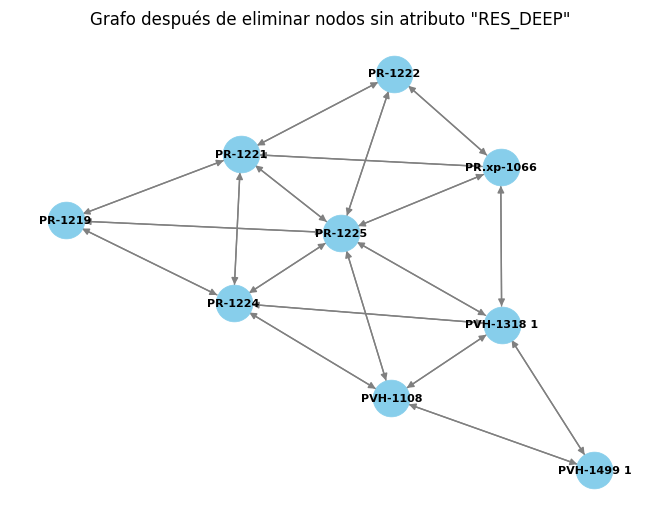

Nodos en G': ['PVH-1318 1', 'PVH-1499 1', 'PVH-1108']
Aristas en G': [('PVH-1318 1', 'PVH-1108'), ('PVH-1318 1', 'PVH-1499 1'), ('PVH-1499 1', 'PVH-1108'), ('PVH-1499 1', 'PVH-1318 1'), ('PVH-1108', 'PVH-1318 1'), ('PVH-1108', 'PVH-1499 1')]


In [7]:
#%%

nodos_a_eliminar = []

# Identificar los nodos que no tienen el atributo 'RES_DEEP' en sus datos
for node in G.nodes():
    if 'RES_DEEP' not in G.nodes[node]['data']:
        nodos_a_eliminar.append(node)

# Eliminar los nodos que no cumplen con la condición
for node in nodos_a_eliminar:
    G.remove_node(node)

# Visualizar el grafo después de la eliminación
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_color='black', font_weight='bold', arrowsize=10, edge_color='gray', linewidths=0.5)

plt.title('Grafo después de eliminar nodos sin atributo "RES_DEEP"')
plt.show()

nodos_test=["PVH-1499 1","PVH-1108","PVH-1318 1"]

# Crea un nuevo grafo G'
G_prime = G.subgraph(nodos_test)

# Imprime la información del nuevo grafo G'
print("Nodos en G':", G_prime.nodes())
print("Aristas en G':", G_prime.edges())

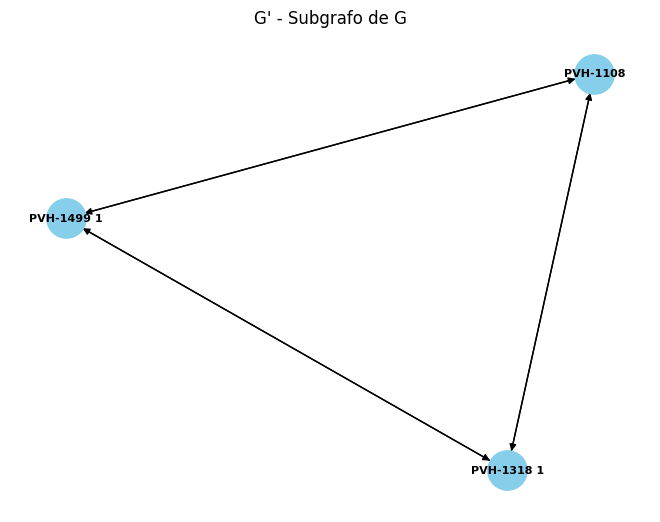

In [8]:
#%%
G=G_prime
# Dibuja el grafo G'
pos = nx.spring_layout(G)  # Selecciona un algoritmo de disposición para los nodos
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, font_size=8)
plt.title('G\' - Subgrafo de G')
plt.show()

In [9]:
#%%

ruta_archivo = ruta_logs +"/Capas O PVH-1318_PVH-1499.xls"

# Leer el archivo usando pandas
tops = pd.read_excel(ruta_archivo)
tops=tops[tops["Pozo"]=="PVH-1318"]
a = tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
tops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(tops)


plt.show()

G.nodes['PVH-1318 1']["tops"]=tops

       Pozo  Capa        Ref
0  PVH-1318   O4T  1600.6632
1  PVH-1318   O5T  1614.4039
2  PVH-1318  O5aT  1624.3099
3  PVH-1318  O5bT  1630.0619
4  PVH-1318   O7T  1639.0092
5  PVH-1318   O4T  1610.2498
6  PVH-1318   O5T  1619.7299
7  PVH-1318  O5aT  1626.8663
8  PVH-1318  O5bT  1633.5769
9  PVH-1318   O7T  1642.5242


In [10]:
#%%
pozo='PVH-1318 1'
#identifico los nodos conectados:
nodos_conectados=list(G.successors(pozo))
print(nodos_conectados)

['PVH-1108', 'PVH-1499 1']


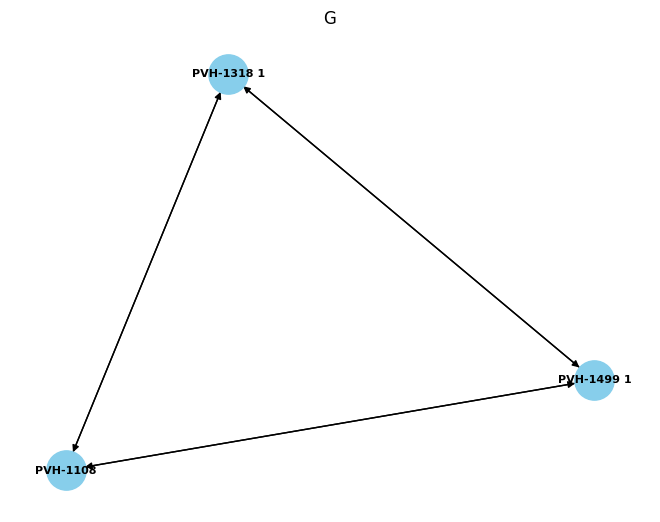

In [11]:
# Display graph G with updates

pos = nx.spring_layout(G)  # Selecciona un algoritmo de disposición para los nodos
nx.draw(G_prime, pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=800, font_size=8)
plt.title('G')
plt.show()

Finally using DTW Algorithm, can start from here.

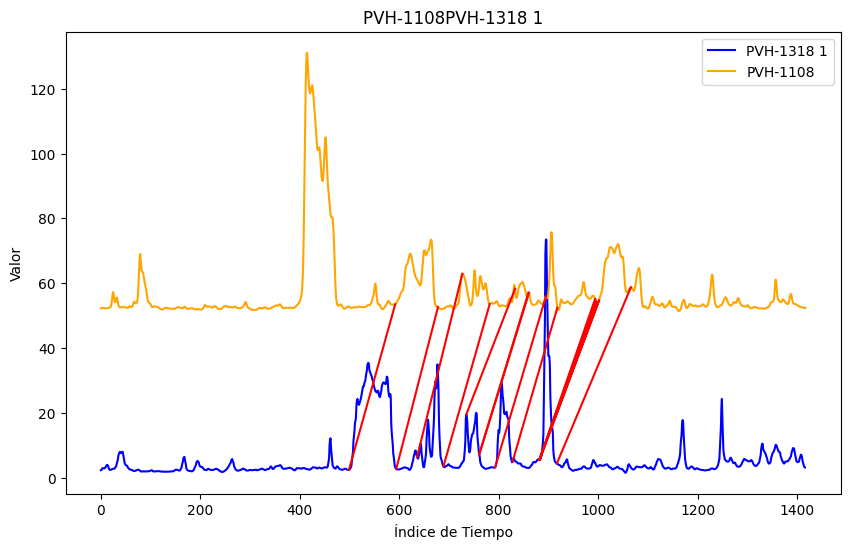

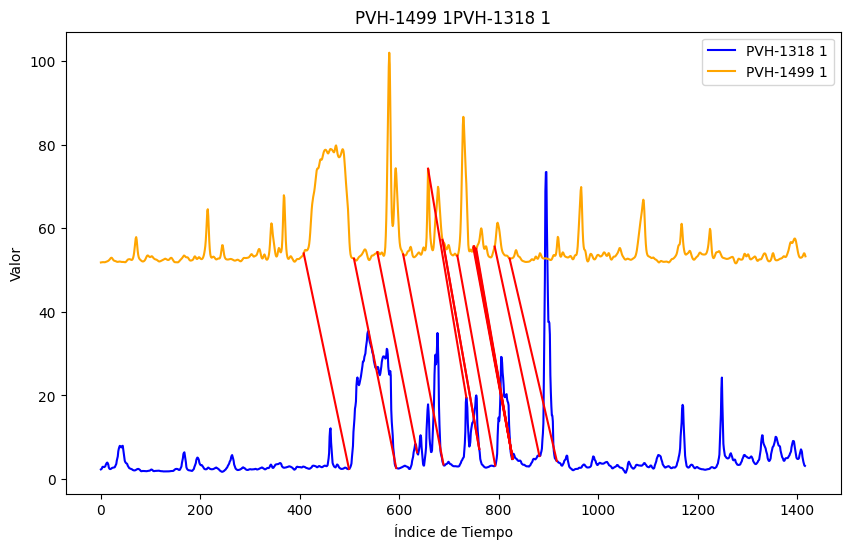

In [12]:
#%%


for nodo in nodos_conectados:
    df1 = G.nodes[pozo]["data"]
    df2 = G.nodes[nodo]["data"]
    tops=G.nodes[pozo]["tops"]
    df1['Present'] = 0
   

    # Definir la tolerancia
    tolerance = 0.05

    # Iterar sobre cada valor en la columna 'DEPTH' de df1
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']

        # Verificar si hay algún valor en la columna 'Ref' de tops dentro de la tolerancia
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)

        # Verificar si hay al menos una coincidencia dentro de la tolerancia
        if matches.any():
            # Si hay coincidencia, establecer el valor en la columna 'Present' como 1
            df1.at[index_df1, 'Present'] = 1

    # Ahora, df1 tiene una nueva columna 'Present' con 1 si hay al menos una coincidencia dentro de la tolerancia, 0 si no

    G.nodes[pozo]["topes"] = df1[df1['Present'] == 1]
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50

    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()

    # Asegúrate de tener df2 definido antes de intentar filtrar
    # Suponiendo que df2 ya está definido y tiene una columna 'DEPTH'
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()

    def normalize_array(arr):
        reshaped_arr = arr.reshape(-1, 1)  # Reshape a una matriz unidimensional
        scaler = MinMaxScaler()
        normalized_arr = scaler.fit_transform(reshaped_arr)
        return normalized_arr

    # Normalizar w1
    w1 = np.array(df1['RES_DEEP'].dropna())
    w1_normalized = normalize_array(w1)
    df1['w1_normalized'] = w1_normalized

    # Normalizar w2
    w2 = np.array(df2['RES_DEEP'].dropna())
    w2_normalized = normalize_array(w2)

    ref=df1[df1["Present"]==1]

    def custom_distance(p1, p2):
        return np.abs(p1 - p2) **(1/ 4.1)



    # Calcula la distancia DTW con tu función de distancia personalizada
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    #limpio el path para gragicar unicment elos topes
    correla = [tupla for tupla in path if tupla[0] in ref.index]
    #idnetifico los tipes del pozo nuevo para guardarlos en el nodo correspondiente:
    correla2=[tupla[1] for tupla in correla]
    #ingresarlo al dataframe corresondiente y guardarlo dentro del nodo
    #df2[pozo]=0
    df2["topes"]=0

    # Verificar coincidencias y actualizar la columna "present"
    for elemento in correla2:
        if elemento in df2.index:
            #df2.loc[elemento, pozo] = 1
            df2.loc[elemento, "topes"] = 1
      
    #G.nodes[nodo]["topes"]=df2[df2[pozo]==1]
    G.nodes[nodo]["topes"]=df2[df2["topes"]==1]
    G.nodes[nodo]["Procesados"]=df2
 
    # Definir un offset para la segunda serie de tiempo
    offset = 50  # Puedes ajustar este valor según sea necesario

    # Graficar las series de tiempo y el camino
    plt.figure(figsize=(10, 6))

    # Graficar la primera serie de tiempo
    plt.plot(df1["RES_DEEP"], label=pozo, color='blue')

    # Graficar la segunda serie de tiempo con offset
    plt.plot(df2["RES_DEEP"] + offset, label=nodo, color='orange')

    # Resaltar el camino calculado por DTW
    for i, j in correla:
        plt.plot([i, j], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(nodo + "" + pozo)
    plt.xlabel('Índice de Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()


PVH-1318 1
PVH-1108


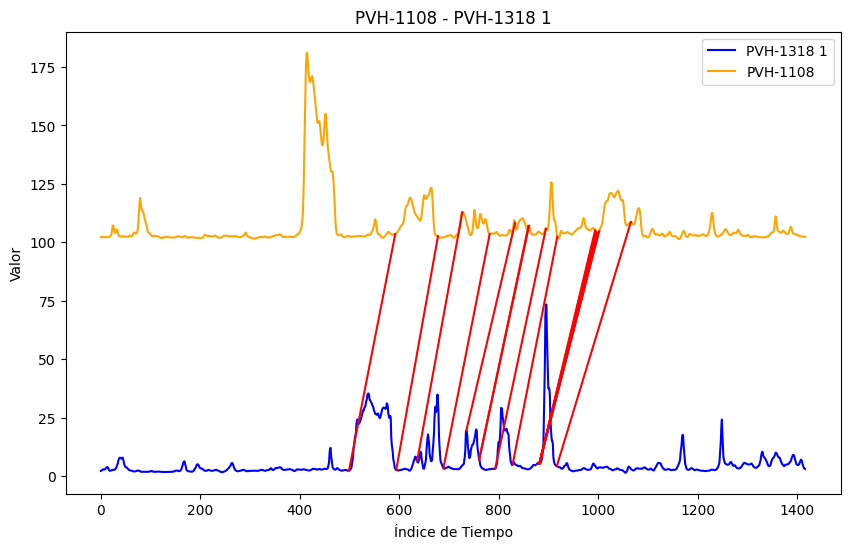

PVH-1499 1


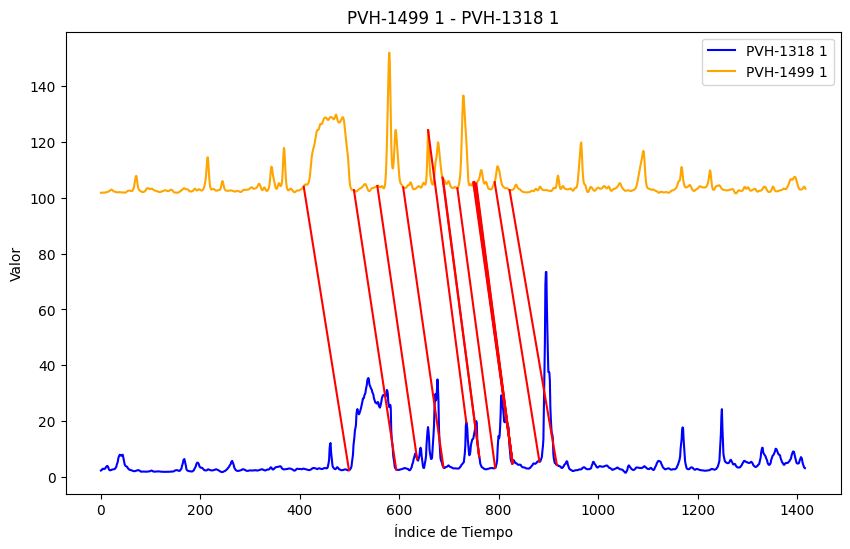

PVH-1499 1
PVH-1108


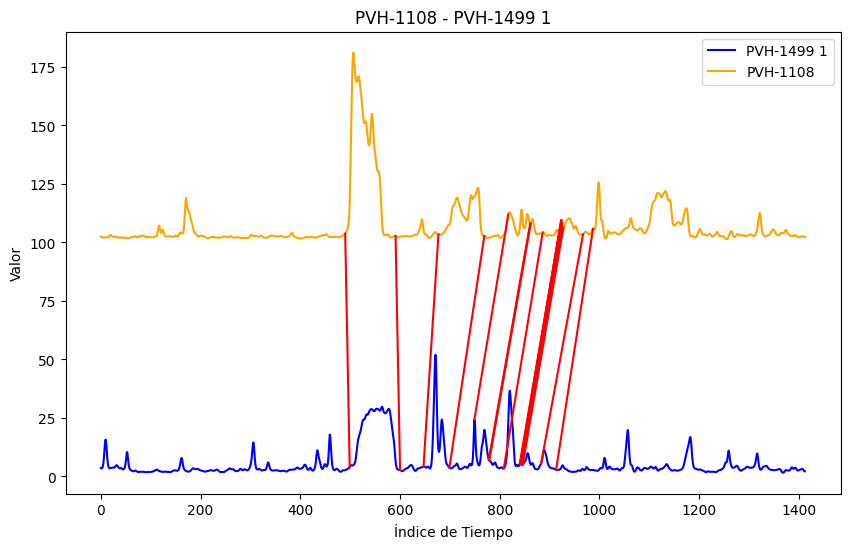

PVH-1318 1


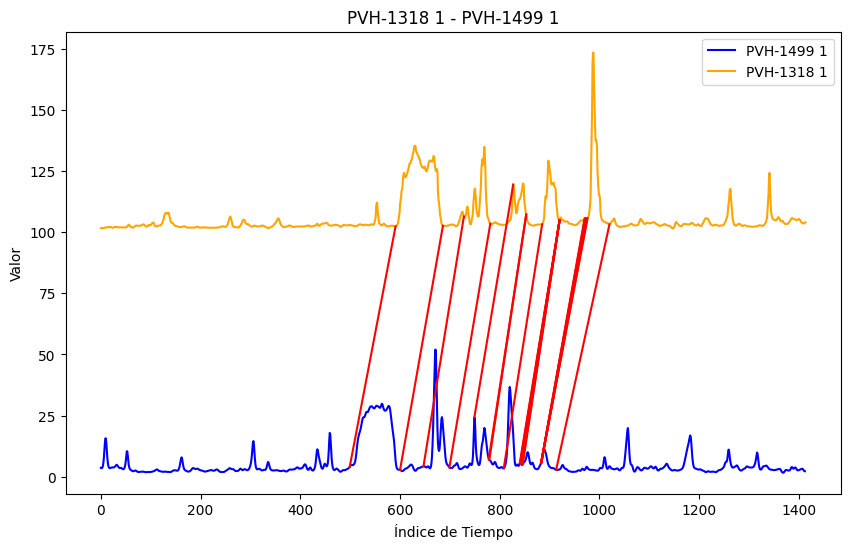

PVH-1108
PVH-1318 1


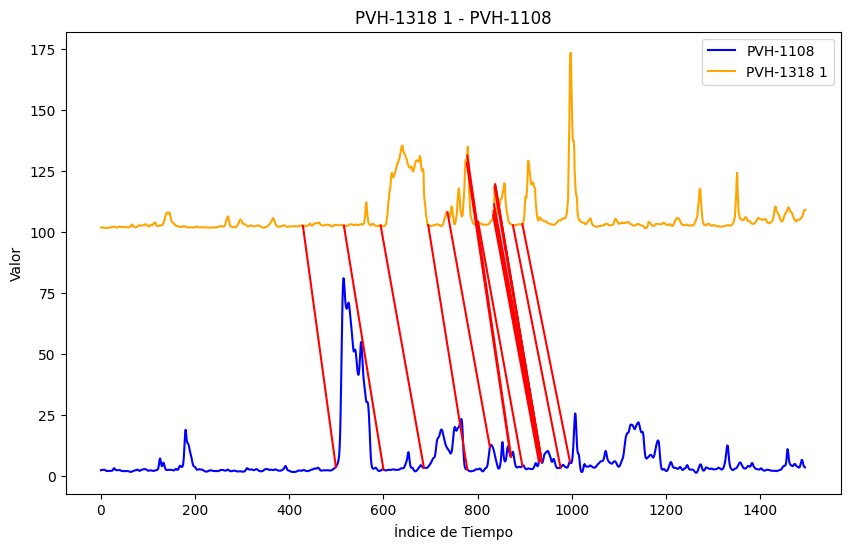

PVH-1499 1


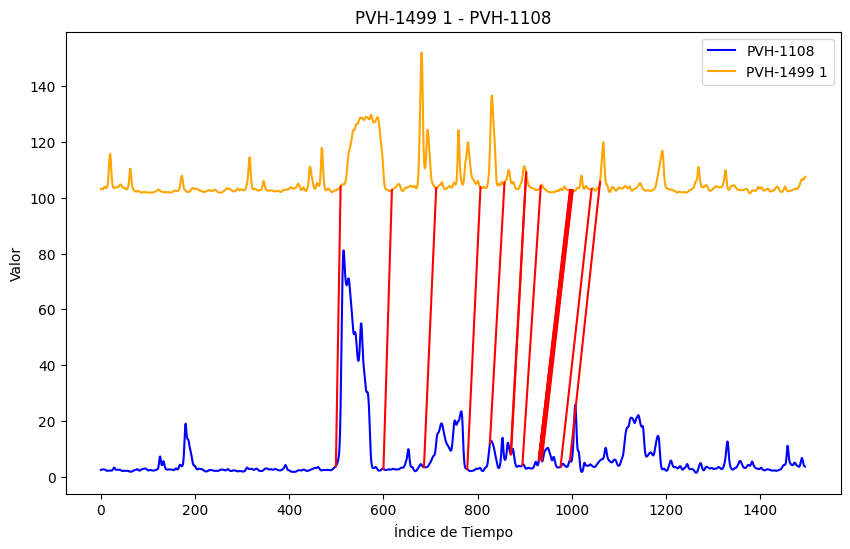

In [13]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import matplotlib.pyplot as plt

# Suponiendo que G ya está definido y contiene nodos con los datos necesarios
for pozo in list(G.nodes):
    nodos_conectados = list(G.successors(pozo))
    print(pozo)
    for nodo in nodos_conectados:
        print(nodo)
        df1 = G.nodes[pozo]["data"]
        df2 = G.nodes[nodo]["data"]
        tops = G.nodes[pozo]["topes"]
        
        # Definir la tolerancia
        tolerance = 0.05

        # Iterar sobre cada valor en la columna 'DEPTH' de df1
        for index_df1, row_df1 in df1.iterrows():
            depth_value = row_df1['DEPTH']

            # Verificar si hay algún valor en la columna 'Ref' de tops dentro de la tolerancia
            matches = tops["DEPTH"].apply(lambda x: np.abs(x - depth_value) <= tolerance)

            # Verificar si hay al menos una coincidencia dentro de la tolerancia
            if matches.any():
                # Si hay coincidencia, establecer el valor en la columna 'Present' como 1
                df1.at[index_df1, 'Present'] = 1

        # Ahora, df1 tiene una nueva columna 'Present' con 1 si hay al menos una coincidencia dentro de la tolerancia, 0 si no
        G.nodes[pozo]["topes"] = df1[df1['Present'] == 1]
        prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
        prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50

        df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()

        # Asegúrate de tener df2 definido antes de intentar filtrar
        df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()

        def normalize_array(arr):
            reshaped_arr = arr.reshape(-1, 1)  # Reshape a una matriz unidimensional
            scaler = MinMaxScaler()
            normalized_arr = scaler.fit_transform(reshaped_arr)
            return normalized_arr

        # Normalizar w1
        w1 = np.array(df1['RES_DEEP'].dropna())
        w1_normalized = normalize_array(w1)
        df1['w1_normalized'] = w1_normalized

        # Normalizar w2
        w2 = np.array(df2['RES_DEEP'].dropna())
        w2_normalized = normalize_array(w2)

        ref = df1[df1["Present"] == 1]

        def custom_distance(p1, p2):
            return np.abs(p1 - p2) ** (1 / 4.1)

        # Calcula la distancia DTW con tu función de distancia personalizada
        distance, path = fastdtw(w1, w2, dist=custom_distance)

        # Limpio el path para graficar únicamente los topes
        correla = [tupla for tupla in path if tupla[0] in ref.index]
        # Identifico los topes del pozo nuevo para guardarlos en el nodo correspondiente
        correla2 = [tupla[1] for tupla in correla]
        # Ingresarlo al dataframe correspondiente y guardarlo dentro del nodo
        df2[pozo] = 0

        # Verificar coincidencias y actualizar la columna "present"
        for elemento in correla2:
            if elemento in df2.index:
                df2.loc[elemento, pozo] = 1

        G.nodes[nodo]["topes"] = df2[df2[pozo] == 1]
        G.nodes[nodo]["data2"] = df2
        G.nodes[pozo]["data2"] = df1
        G[pozo][nodo]["correla"] = correla

        # Definir un offset para la segunda serie de tiempo
        offset = 100  # Puedes ajustar este valor según sea necesario

        # Graficar las series de tiempo y el camino
        plt.figure(figsize=(10, 6))

        # Graficar la primera serie de tiempo
        plt.plot(df1["RES_DEEP"], label=pozo, color='blue')

        # Graficar la segunda serie de tiempo con offset
        plt.plot(df2["RES_DEEP"] + offset, label=nodo, color='orange')

        # Resaltar el camino calculado por DTW
        for i, j in correla:
            plt.plot([i, j], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

        plt.title(f'{nodo} - {pozo}')
        plt.xlabel('Índice de Tiempo')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()



